# Arize Tutorial: Model Type - Numeric

Let's get started on using Arize!✨

Arize helps you visualize your model performance, understand drift & data quality issues, and share insights learned from your models.

In this tutorial, we will be building a model to predict Boston House Prices. The model is predicting a numeric value so we call it a `ModelType.NUMERIC`. After that, we will load the models's training inferences and test inferences into Arize. 🚀.

### Running This Notebook
1. Save a copy in Google Drive for yourself.
2. Step through each section below, pressing play on the code blocks to run the cells.
3. In Step 2, use your own Space and API key from your Arize account.


## Step 1: Load Data and Build Model

In [ ]:
import pandas as pd
import uuid
import concurrent.futures as cf
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split

###############################################################################
# 1 Load data and split data
data = datasets.load_boston()
X, y = datasets.load_boston(return_X_y=True)
X, y = pd.DataFrame(X, columns=data['feature_names']), pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

###############################################################################
# 2 Fit a regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 0.5,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params).fit(X_train, y_train)

# 3 Use the model to generate predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

print('Step 1 ✅: Load Data & Build Model Done!')

Step 1 ✅: Load Data & Build Model Done!


## Step 2: Import and Setup Arize Client
You can find your `API_KEY` and `SPACE_KEY` by navigating to the settings page in your workspace (only space admins can see the keys). Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.
<img src="https://storage.googleapis.com/arize-assets/fixtures/copy-keys-4.0.0.png" width="600">

In [ ]:
!pip install arize -q
from arize.api import Client
from arize.utils.types import ModelTypes

SPACE_KEY = 'SPACE_KEY'
API_KEY = 'API_KEY'
arize = Client(space_key=SPACE_KEY, api_key=API_KEY)

# Saving model metadata for passing in later
model_id = 'boston_house_prices'
model_version = '1.0'
model_type = ModelTypes.NUMERIC

print('Step 2 ✅: Import and Setup Arize Client Done! Now we can start using Arize!')

     |████████████████████████████████| 1.3MB 6.4MB/s 
ERROR: tensorflow-metadata 0.29.0 has requirement googleapis-common-protos<2,>=1.52.0, but you'll have googleapis-common-protos 1.51.0 which is incompatible.
Step 2 ✅: Import and Setup Arize Client Done! Now we can start using Arize!


## Step 3: Log Training Inferences to Arize
First step: Log the training data for your model to Arize!

In [ ]:
# Logging training
train_prediction_labels = pd.Series(y_train_pred)
train_actual_labels = pd.Series(y_train)
train_feature_df = pd.DataFrame(X_train, columns=data['feature_names'])

train_responses = arize.log_training_records(
    model_id=model_id,
    model_version=model_version,
    model_type=model_type, # this will change depending on your model type
    prediction_labels=train_prediction_labels,
    actual_labels=train_actual_labels,
    features=train_feature_df,
    )

## Helper to listen to response code to ensure successful delivery
def arize_responses_helper(responses):
  for response in cf.as_completed(responses):
    res = response.result()
    if res.status_code != 200:
      print(f'future failed with response code {res.status_code}, {res.text}')

arize_responses_helper(train_responses)

print('Step 3 ✅: If no errors showed up, you have sent Training Inferences!')

Step 3 ✅: If no errors showed up, you have sent Training Inferences!


## Step 4: Log Validation Inferences to Arize
Next Step: Log the validation data. You need to include `batch_id` to separate out different validation sets.

In [ ]:
# Logging validation
val_prediction_labels = pd.Series(y_val_pred)
val_actual_labels = pd.Series(y_val)
val_features_df = pd.DataFrame(X_val, columns=data['feature_names'])

val_responses = arize.log_validation_records(
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    batch_id='batch0',
    prediction_labels=val_prediction_labels,
    actual_labels=val_actual_labels,
    features=val_features_df,
    )

arize_responses_helper(val_responses)
print('Step 4 ✅: If no errors showed up, you have sent Validation Inferences!')

Step 4 ✅: If no errors showed up, you have sent Validation Inferences!


# Logging During Production
Next steps simulate production environment

## Step 5: Generating and Formatting SHAP Values
**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model.

For more in-depth usage of the `shap` library, visit [SHAP Core Explainers](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.Explainer.html) and pick an explainer specific to your machine learning model. `shap.Explainer` is the default explainer that will matches model type, but you can specify your own type. For example, you can choose to use `shap.TreeExplainer`, but it won't work on models such as `sklearn.LinearModel.LogisticRegression`.

We create this helper function `get_shap_values` to format the data and/or create visualizations for our shap values. We will store our results in a `pd.DataFrame` with matching columns for logging later.

     |████████████████████████████████| 358kB 6.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491623 sha256=c754bc7befe1c9cc586e77c8235ede5df7e19868e013aa2165e8c73ef75e98cb
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


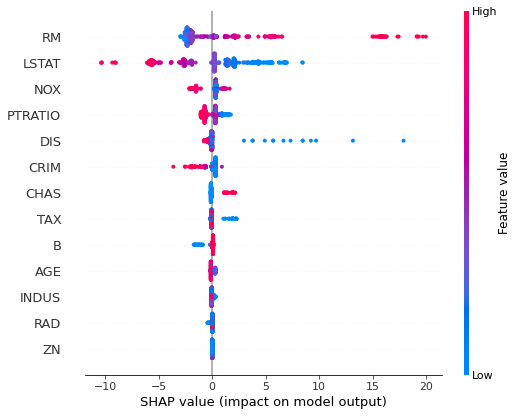

Step 5 ✅: If no errors showed up, you should see a SHAP Graph above here!


In [ ]:
!pip install shap
import shap

def get_shap_values(model, X_data, ExplainerType=shap.Explainer, show_graph=False):
    # NOTE: If there are errors, you  need to manually choose which explainer class
    explainer = ExplainerType(model, X_data)
    shap_values = explainer.shap_values(X_data)

    # When not in production, it can be helpful to check graphs for feature explainability
    if show_graph:
        shap.summary_plot(shap_values, X_data, feature_names=data['feature_names'])

    # NOTE: Arize API expects a DataFrame of the same shape and column name as the model features.
    return pd.DataFrame(shap_values, columns=data['feature_names'])

shap_values = get_shap_values(clf, X, show_graph=True)
print('Step 5 ✅: If no errors showed up, you should see a SHAP Graph above here!')

## Step 6: Production Logging in Bulk to Arize
Note: We will be sending our test data to emulate sending production data.

1. **prediction_timestamps:** You can directly specify the unix time which the predictions were made by using the optional argument `time_overwrite`. This will set the prediction timestamps. It can be a `pd.Series` or `List` of dtype `int` and the same length as the predictions sent. The timestamp at index 1 will be the prediction timestamp at index 1. You can set the prediction timestamps within the last year.

In our example, we used `time_overwrite` to simulate predictions over 30 days so you can see it displayed on arize platform right away.

In [ ]:
import numpy as np
import datetime

# bulk_pred_ids_df will be used to uniquely identify these predictions
ids_df = pd.DataFrame([str(uuid.uuid4()) for _ in range(len(y_test))])
y_pred = pd.Series(clf.predict(X_test))

# OPTIONAL: Simulate predictions evenly distributed over 30 days by manually specifying prediction time
current_time = datetime.datetime.now().timestamp()
earlier_time = (datetime.datetime.now() - datetime.timedelta(days=30)).timestamp()
optional_prediction_timestamps = np.linspace(earlier_time, current_time, num=len(y_test_pred))
optional_prediction_timestamps = pd.Series(optional_prediction_timestamps.astype(int))

# Generate SHAP vales
shap_df = get_shap_values(clf, X_test)

# First we log the predictions and actuals.
log_bulk_responses = arize.bulk_log(
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    prediction_ids=ids_df,
    prediction_labels=y_pred,
    actual_labels=y_test,
    prediction_timestamps=optional_prediction_timestamps,
    shap_values=shap_df,
    features=X_test,
    )

arize_responses_helper(log_bulk_responses)
print('Step 6 ✅: If no errors showed up, you have logged predictions and actuals in bulk!')

Step 6 ✅: If no errors showed up, you have logged predictions and actuals in bulk!


### Overview
Arize is an end-to-end ML observability and model monitoring platform. The platform is designed to help ML engineers and data science practitioners surface and fix issues with ML models in production faster with:
- Automated ML monitoring and model monitoring
- Workflows to troubleshoot model performance
- Real-time visualizations for model performance monitoring, data quality monitoring, and drift monitoring
- Model prediction cohort analysis
- Pre-deployment model validation
- Integrated model explainability

### Website
Visit Us At: https://arize.com/model-monitoring/

### Additional Resources
- [What is ML observability?](https://arize.com/what-is-ml-observability/)
- [Playbook to model monitoring in production](https://arize.com/the-playbook-to-monitor-your-models-performance-in-production/)
- [Using statistical distance metrics for ML monitoring and observability](https://arize.com/using-statistical-distance-metrics-for-machine-learning-observability/)
- [ML infrastructure tools for data preparation](https://arize.com/ml-infrastructure-tools-for-data-preparation/)
- [ML infrastructure tools for model building](https://arize.com/ml-infrastructure-tools-for-model-building/)
- [ML infrastructure tools for production](https://arize.com/ml-infrastructure-tools-for-production-part-1/)
- [ML infrastructure tools for model deployment and model serving](https://arize.com/ml-infrastructure-tools-for-production-part-2-model-deployment-and-serving/)
- [ML infrastructure tools for ML monitoring and observability](https://arize.com/ml-infrastructure-tools-ml-observability/)

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.
